In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install catboost -q
!pip install numba -q

     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [4]:
import numpy as np
from numba import jit
import pandas as pd
import shutil
import seaborn as sns
from time import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#from sklearn.preprocessing import One_Hot_Encoder
from sklearn.metrics import accuracy_score
from multiprocessing import  Pool
import os
from itertools import product

In [5]:
os.cpu_count()

2

In [6]:
data=pd.read_csv('/content/drive/MyDrive/rcgautograd7.csv')

In [7]:
input=data[data.columns[:7]]
output=data[data.columns[-7:]]

In [8]:
X=np.zeros((input.shape[0],21))
y=np.zeros((input.shape[0],21),'int16')
for ind,x in enumerate(input.values.astype(int)):
  X[ind,x]=1#range(1,6)[::-1]
for ind,n in enumerate(output.values.astype(int)):
  y[ind,n]=1

In [9]:
def my_metric(pred,actual):
  number=[]
  for ind,pre in enumerate(pred):
    act=np.argsort(actual[ind])[-7:]
    number.append(np.isin(act,pre).sum())
  return np.mean(number)
def top_7(value):
  li=[]
  for val in value:
    li.append(list(np.argsort(val)[-7:]))
  return li

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb 
from catboost import CatBoostClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,shuffle=True)
actual_locs=top_7(y_test)

In [11]:
train=np.concatenate([X_train,y_train[:,0].reshape(-1,1)],axis=1)

In [12]:
#np.repeat(X_test[0].reshape(1,-1),6,axis=0)

In [13]:
from random import seed
from random import randrange
from csv import reader
from math import sqrt
 
# calculate the Euclidean distance between two vectors
@jit(nopython=True)
def euclidean_distance(row1, row2):
  dist = np.linalg.norm(row1[:21]-row2[:21])
  return dist
  #  distance = 0.0
  #  for i in range(len(row1)-1):
   #     distance += (row1[i] - row2[i])**2
   # return sqrt(distance)
 
# Locate the best matching unit
@jit(nopython=True)
def get_best_matching_unit(codebooks, test_row):
  #dists=np.apply_along_axis(euclidean_distance,1,codebooks,test_row)
 # return codebooks[np.argmin(dists)]
    distances = list()
    for codebook in codebooks:
       dist = euclidean_distance(codebook, test_row)
       distances.append((codebook, dist))
    distances.sort(key=lambda tup: tup[1])
    return distances[0][0]
def get_best_k_matching_units(codebooks,test_row,k):
  distances = list()
  for codebook in codebooks:
      dist = euclidean_distance(codebook, test_row)
      distances.append((codebook, dist))
  distances.sort(key=lambda tup: tup[1])
  return distances[:k]
@jit(nopython=True)
def get_closest_1(codebooks,test_row):
  distances = list()
  for codebook in codebooks :
    if codebook[-1]==1:
      dist = euclidean_distance(codebook, test_row)
      distances.append((codebook, dist))
  if distances:
    distances.sort(key=lambda tup: tup[1])
    return distances[0][1]
  else :
    return 1000
# Make a prediction with codebook vectors
@jit(nopython=True)
def predict_best(codebooks, test_row):
    bmu = get_best_matching_unit(codebooks, test_row)
    return bmu[-1]

def random_codebook(train,n_codebooks):
    code_indices=np.random.choice(range(train.shape[0]),n_codebooks,replace=False)
    codebooks=train[code_indices]
    return codebooks
 
# Train a set of codebook vectors

def train_codebooks(train, self):
    codebooks=random_codebook(train,self.n_codebooks)
    for epoch in range(self.n_epochs):
        rate = self.lr * (1.0-(epoch/float(self.n_epochs)))
        for row in train:
            bmu = get_best_matching_unit(codebooks, row)
            error= row[:-1] - bmu[:-1]
            if bmu[-1] == row[-1]:
              bmu[:-1] += rate * error
            else:
                    bmu[:-1] -= rate * error
           # for i in range(len(row)-1):
            #    error = row[i] - bmu[i]
            #    if bmu[-1] == row[-1]:
            #        bmu[i] += rate * error
             #   else:
             #       bmu[i] -= rate * error
    return codebooks
 
# LVQ Algorithm
#n_folds = 5
#learn_rate = 0.3
#n_epochs = 50
#n_codebooks = 20

In [14]:
class LVQ():
  def __init__(self,n_codebooks=50,k=10,n_epochs=10,lr=0.3,seed=42):
        self.n_codebooks = n_codebooks
        self.n_epochs = n_epochs
        self.k = k
        self.lr = lr
        self.seed=seed
  def fit(self,X_train,y_train):
    train=np.concatenate([X_train,y_train.reshape(-1,1)],axis=1)
    np.random.seed(self.seed)
    trained_codebooks=train_codebooks(train,self)
    self.trained_codebooks=trained_codebooks
    return trained_codebooks
  def predict(self,test_X):
    self.preds=np.zeros(test_X.shape[0])
    for num,test_row in enumerate(test_X):
        self.preds[num]=predict_best(self.trained_codebooks,test_row)
    return self.preds 
  def predict_distances(self,test_X):
    k_closest=np.zeros((test_X.shape[0],self.k))
    for num,test_row in enumerate(test_X):
        k_best=get_best_k_matching_units(self.trained_codebooks,test_row,self.k)
        for ind,dist in enumerate(k_best):
          if dist[0][-1]==0:
            k_closest[num,ind]=dist[1]*-1
          else :
            k_closest[num,ind]=dist[1]
    return k_closest
  def predict_proba(self,test_X):
    closest=np.zeros((test_X.shape[0]))
    for num,test_row in enumerate(test_X):
        closest[num]=1/(get_closest_1(self.trained_codebooks,test_row))
    return closest

In [15]:
class multi_class():
  def __init__(self,model):
        self.n_codebooks = model.n_codebooks
        self.n_epochs = model.n_epochs
        self.k = model.k
        self.lr = model.lr
        self.seed=model.seed
        self.model=model
        self.codebooks=[]
  def fit(self,X,y):
    self.n_classes=y.shape[1]
    for num in tqdm(range(y.shape[1])):
      model=self.model
      model=model.fit(X,y[:,num])
      self.codebooks.append(model)
  def new_fit(self,X,y):
    self.n_classes=y.shape[1]
    if __name__ == '__main__':
      pool = Pool()                        
      self.codebooks=list(pool.starmap(self.model.fit, zip(np.repeat(X[None,:],self.n_classes,axis=0),np.transpose(y))))
  def predict(self,test):
    preds=np.zeros((test.shape[0],self.n_classes))
    for num,codebook in enumerate(self.codebooks):
      for ind,test_row in enumerate(test):
        bmu = get_best_matching_unit(codebook, test_row)
        preds[ind,num]=bmu[-1]
    return preds
  def predict_proba(self,test_X):
    preds=np.zeros((test_X.shape[0],self.n_classes))
    for num,model in enumerate(self.codebooks):
      for ind,test_row in enumerate(test_X):
        preds[ind,num]=1/(get_closest_1(model,test_row)) 
    return preds

In [16]:
# creating dummy_model i.e random predictions
import random,numpy
# seeding the environment to enable reproductibility of results
seed=12
np.random.seed(seed)
rand_cities =np.random.choice(range(y_train.shape[1]),(X_test.shape[0],5))
random_test_score=my_metric(rand_cities,y_test)
print("Mean no of accurate locations for test ",random_test_score )

Mean no of accurate locations for test  1.5266666666666666


In [17]:
def eval_model(model):
  test_acc=accuracy_score(y_test.reshape(-1),model.predict(X_test).reshape(-1))
  train_acc=accuracy_score(y_train.reshape(-1),model.predict(X_train).reshape(-1))
  return train_acc,test_acc

In [18]:
fit_time=[]
predict_time=[]
models=[]
test_scores=[]
train_scores=[]
test_acc=[]
train_acc=[]
descr=[]
def save_model_info(fit,predict,model,test_score,train_score,train,test,desc):
  fit_time.append(fit)
  predict_time.append(predict)
  models.append(model)
  test_acc.append(test)
  train_acc.append(train)
  test_scores.append(test_score)
  train_scores.append(train_score)
  descr.append(desc)

In [19]:
%%capture
#import futures
'''executor = futures.ProcessPoolExecutor(10)
futures = [executor.submit(try_my_operation, item) for item in items]
futures.wait(futures)'''

In [20]:
# set the range of parameters for the model to try 
params_dict={'lr':[0.1,0.2,0.05],
             'n_codebooks':[20,40,50],
             'n_epochs':[10,20,50]}

In [21]:
#params=list(params_dict.keys())
#all_vals=list(product(*list(params_dict.values())))
#for vals in all_vals:
 # res = dict(zip(params, vals))
  #lv=LVQ()
  #list(map(lambda item: setattr(lv, *item), res.items()))
  #print(('Training with parameters '+': {} '.join(params)+': {}').format(*vals))
  #mc=multi_class(lv)
  #mc.new_fit(X_train,y_train)
  #lvq_proba=mc.predict_proba(X_test)
  #predicted_locs=top_5(lvq_proba)
  #test_score=my_metric(predicted_locs,y_test)
  #print("Mean no of accurate locations for test ",test_score)
  #train_accuracy,test_accuracy=eval_model(mc)
  #print("accuracy for test ",test_accuracy)
  #print("accuracy for train ",train_accuracy)

In [22]:
lv=LVQ(n_codebooks=40,lr=0.2,n_epochs=70)
lvqmc=multi_class(lv)
start_fit=time()
lvqmc.fit(X_train,y_train)
end_fit=time()
lvq_proba=lvqmc.predict_proba(X_test)
lvq_train_proba=lvqmc.predict_proba(X_train)
end_pred=time()
predicted_locs=top_7(lvq_proba)
test_score=my_metric(predicted_locs,y_test)
train_score=my_metric(top_7(lvq_train_proba),y_train)
print("Mean no of accurate locations for test ",test_score)
print("Mean no of accurate locations for train ",train_score)
train_accuracy,test_accuracy=eval_model(lvqmc)
print("accuracy for test ",test_accuracy)
print("accuracy for train ",train_accuracy)
save_model_info(end_fit-start_fit,end_pred-end_fit,'lvqmc',test_score,train_score,train_accuracy,test_accuracy,'lvq model with 50 codebooks')

100%|██████████| 21/21 [01:23<00:00,  3.99s/it]


Mean no of accurate locations for test  5.126666666666667
Mean no of accurate locations for train  5.6651428571428575
accuracy for test  0.8445079365079365
accuracy for train  0.9082721088435374


In [23]:
lv=LVQ(n_codebooks=40,lr=0.2,n_epochs=70)
mc=multi_class(lv)
start_fit=time()
mc.new_fit(X_train,y_train)
end_fit=time()
lvq_proba=mc.predict_proba(X_test)
lvq_train_proba=mc.predict_proba(X_train)
end_pred=time()
predicted_locs=top_7(lvq_proba)
test_score=my_metric(predicted_locs,y_test)
train_score=my_metric(top_7(lvq_train_proba),y_train)
print("Mean no of accurate locations for test ",test_score)
print("Mean no of accurate locations for train ",train_score)
train_accuracy,test_accuracy=eval_model(mc)
print("accuracy for test ",test_accuracy)
print("accuracy for train ",train_accuracy)
save_model_info(end_fit-start_fit,end_pred-end_fit,'mcLVQ',test_score,train_score,train_accuracy,test_accuracy,'lvq model with multiprocessing')
predicted_locs[:10]

Mean no of accurate locations for test  5.126666666666667
Mean no of accurate locations for train  5.6651428571428575
accuracy for test  0.8445079365079365
accuracy for train  0.9082721088435374


[[9, 17, 16, 18, 13, 20, 19],
 [2, 17, 18, 20, 16, 13, 11],
 [20, 7, 17, 1, 14, 11, 9],
 [6, 15, 8, 16, 7, 9, 11],
 [11, 20, 16, 19, 15, 1, 17],
 [1, 16, 20, 18, 10, 17, 9],
 [5, 2, 15, 9, 16, 3, 20],
 [3, 18, 2, 16, 17, 6, 20],
 [17, 16, 14, 20, 11, 7, 1],
 [10, 17, 6, 9, 2, 20, 19]]

In [24]:
actual_locs[:10]

[[9, 19, 13, 2, 16, 17, 20],
 [6, 11, 13, 2, 16, 18, 20],
 [9, 11, 14, 16, 1, 7, 20],
 [8, 9, 5, 11, 13, 15, 17],
 [5, 9, 11, 12, 15, 17, 18],
 [17, 16, 10, 9, 1, 15, 20],
 [16, 0, 7, 5, 3, 11, 20],
 [9, 5, 14, 2, 16, 17, 20],
 [11, 14, 1, 16, 17, 18, 20],
 [18, 17, 0, 6, 5, 9, 20]]

In [25]:
fit_time

[83.76445531845093, 55.9661545753479]

In [26]:
from sklearn.neighbors import KNeighborsClassifier
kn=KNeighborsClassifier(n_neighbors=150)
knn=MultiOutputClassifier(kn)
start_fit=time()
knn.fit(X_train,y_train)
end_fit=time()
knn_proba=np.stack(knn.predict_proba(X_test), axis=1 )[:,:,1]
knn_train_proba=np.stack(knn.predict_proba(X_train), axis=1 )[:,:,1]
end_pred=time()
predicted_locs=top_7(knn_proba) 
test_score=my_metric(predicted_locs,y_test)
train_score=my_metric(top_7(knn_train_proba),y_train)
print("Mean no of accurate locations for test ",test_score)
print("Mean no of accurate locations for train ",train_score)
train_accuracy,test_accuracy=eval_model(knn)
print("accuracy for train ",train_accuracy)
print("accuracy for test ",test_accuracy)
save_model_info(end_fit-start_fit,end_pred-end_fit,'knn',test_score,train_score,train_accuracy,test_accuracy,'KNearestNeighborsClassifier with k as 150')

Mean no of accurate locations for test  5.244
Mean no of accurate locations for train  5.287428571428571
accuracy for train  0.8188571428571428
accuracy for test  0.8158095238095238


In [27]:
r=RandomForestClassifier(n_estimators=500,max_depth=20,min_samples_split=2,max_features=0.2,random_state=12, max_samples=0.8)
rf=MultiOutputClassifier(r)
start_fit=time()
rf.fit(X_train,y_train)
end_fit=time()
rf_proba=np.stack(rf.predict_proba(X_test), axis=1 )[:,:,1]
rf_train_proba=np.stack(rf.predict_proba(X_train), axis=1 )[:,:,1]
end_pred=time()
predicted_locs=top_7(rf_proba)
test_score=my_metric(predicted_locs,y_test)
train_score=my_metric(top_7(rf_train_proba),y_train)
print("Mean no of accurate locations for test ",test_score )
print("Mean no of accurate locations for train ",train_score )
train_accuracy,test_accuracy=eval_model(rf)
print("accuracy for train ",train_accuracy)
print("accuracy for test ",test_accuracy)
save_model_info(end_fit-start_fit,end_pred-end_fit,'rf',test_score,train_score,train_accuracy,test_accuracy,'RandomForest with depth of 20')

Mean no of accurate locations for test  5.834666666666666
Mean no of accurate locations for train  7.0
accuracy for train  1.0
accuracy for test  0.8882539682539683


In [28]:
l=LogisticRegression(C=1,max_iter=1000)
lr=MultiOutputClassifier(l)
start_fit=time()
lr.fit(X_train,y_train)
end_fit=time()
lr_proba=np.stack(lr.predict_proba(X_test), axis=1 )[:,:,1]
lr_train_proba=np.stack(lr.predict_proba(X_train), axis=1 )[:,:,1]
end_pred=time()
predicted_locs=top_7(lr_proba)
test_score=my_metric(predicted_locs,y_test)
train_score=my_metric(top_7(lr_train_proba),y_train)
print("Mean no of accurate locations for test ",test_score )
print("Mean no of accurate locations for train ",train_score )
train_accuracy,test_accuracy=eval_model(lr)
print("accuracy for train ",train_accuracy)
print("accuracy for test ",test_accuracy)
save_model_info(end_fit-start_fit,end_pred-end_fit,'lr',test_score,train_score,train_accuracy,test_accuracy,' A basic logistic regression with C as 10')

Mean no of accurate locations for test  5.534666666666666
Mean no of accurate locations for train  5.524571428571429
accuracy for train  0.8606530612244898
accuracy for test  0.8620952380952381


In [29]:
xg=XGBClassifier(n_estimators=650 , max_depth=5, learning_rate=0.08,colsample_bytree=0.25,
                  random_state=12,subsample=0.8)
xgb=MultiOutputClassifier(xg)
start_fit=time()
xgb.fit(X_train,y_train)
end_fit=time()
xgb_proba=np.stack(xgb.predict_proba(X_test), axis=1 )[:,:,1]
xgb_train_proba=np.stack(xgb.predict_proba(X_train), axis=1 )[:,:,1]
end_pred=time()
predicted_locs=top_7(xgb_proba)
test_score=my_metric(predicted_locs,y_test)
train_score=my_metric(top_7(xgb_train_proba),y_train)
print("Mean no of accurate locations for test ",test_score )
print("Mean no of accurate locations for train ",train_score )
train_accuracy,test_accuracy=eval_model(xgb)
print("accuracy for train ",train_accuracy)
print("accuracy for test ",test_accuracy)
save_model_info(end_fit-start_fit,end_pred-end_fit,'xgb',test_score,train_score,train_accuracy,test_accuracy,'A simple xgboost model')

Mean no of accurate locations for test  5.808
Mean no of accurate locations for train  6.809142857142857
accuracy for train  0.9764353741496599
accuracy for test  0.8869206349206349


In [30]:
ct= CatBoostClassifier(loss_function= 'MultiClass',learning_rate= 0.08,iterations= 600,depth= 6,
                        subsample=0.8,bootstrap_type='Bernoulli',colsample_bylevel=0.2,random_seed= 12,verbose= False)
cat=MultiOutputClassifier(ct)
start_fit=time()
cat.fit(X_train,y_train)
end_fit=time()
cat_proba=np.stack(cat.predict_proba(X_test), axis=1 )[:,:,1]
cat_train_proba=np.stack(cat.predict_proba(X_train), axis=1 )[:,:,1]
end_pred=time()
predicted_locs=top_7(cat_proba)
test_score=my_metric(predicted_locs,y_test)
train_score=my_metric(top_7(cat_train_proba),y_train)
print("Mean no of accurate locations for test ",test_score )
print("Mean no of accurate locations for train ",train_score )
train_accuracy,test_accuracy=eval_model(cat)
print("accuracy for train ",train_accuracy)
print("accuracy for test ",test_accuracy)
save_model_info(end_fit-start_fit,end_pred-end_fit,'cat',test_score,train_score,train_accuracy,test_accuracy,'A catboost model')

Mean no of accurate locations for test  5.918666666666667
Mean no of accurate locations for train  6.997714285714285
accuracy for train  0.9993741496598639
accuracy for test  0.8963809523809524


In [31]:
vot=VotingClassifier([('xg',xg),('rf',r),('cat',ct)],voting='soft',weights=[0.2,0.6,0.8])
vote=MultiOutputClassifier(vot)
start_fit=time()
vote.fit(X_train,y_train)
end_fit=time()
vote_proba=np.stack(vote.predict_proba(X_test), axis=1 )[:,:,1]
vote_train_proba=np.stack(vote.predict_proba(X_train), axis=1 )[:,:,1]
end_pred=time()
predicted_locs=top_7(vote_proba)
test_score=my_metric(predicted_locs,y_test)
train_score=my_metric(top_7(vote_train_proba),y_train)
print("Mean no of accurate locations for test ",test_score )
print("Mean no of accurate locations for train ",train_score )
train_accuracy,test_accuracy=eval_model(vote)
print("accuracy for train ",train_accuracy)
print("accuracy for test ",test_accuracy)
save_model_info(end_fit-start_fit,end_pred-end_fit,'vote',test_score,train_score,train_accuracy,test_accuracy,'An ensemble of xgboost,random_forest and catboost')

Mean no of accurate locations for test  5.906666666666666
Mean no of accurate locations for train  6.997714285714285
accuracy for train  0.9995918367346939
accuracy for test  0.8954285714285715


In [46]:
results_df=pd.DataFrame({'fit_time(secs)':fit_time,'predict_time(secs)':predict_time,'train_acc':train_acc,'test_acc':test_acc,'train_score':train_scores,'test_score':test_scores,'model':models,'description':descr})
results_df.drop_duplicates(['model'],keep='last',inplace=True)
results_df2=pd.read_csv('/content/drive/MyDrive/resultsnew.csv')
results_df=pd.concat([results_df,results_df2])
results_df.reset_index(drop=True,inplace=True)

In [47]:
results_df

,fit_time(secs),predict_time(secs),train_acc,test_acc,train_score,test_score,model,description,Unnamed: 0
0,83.764455,1.880910,0.908272,0.844508,5.665143,5.126667,lvqmc,lvq model with 50 codebooks,NaN
1,55.966155,0.450645,0.908272,0.844508,5.665143,5.126667,mcLVQ,lvq model with multiprocessing,NaN
2,0.020595,2.742778,0.818857,0.815810,5.287429,5.244000,knn,KNearestNeighborsClassifier with k as 150,NaN
3,18.997462,5.637978,1.000000,0.888254,7.000000,5.834667,rf,RandomForest with depth of 20,NaN
4,0.288847,0.009351,0.860653,0.862095,5.524571,5.534667,lr,A basic logistic regression with C as 10,NaN
5,14.284174,1.636899,0.976435,0.886921,6.809143,5.808000,xgb,A simple xgboost model,NaN
6,24.656379,0.492867,0.999374,0.896381,6.997714,5.918667,cat,A catboost model,NaN
7,59.337128,7.603340,0.999592,0.895429,6.997714,5.906667,vote,"An ensemble of xgboost,random_forest and catboost",NaN
8,145.457107,4.600025,0.794222,0.793605,4.002286,3.982667,gnn,Graph Neural Network,0.0
9,45.347118,0.996642,0.893524,0.879365,5.724571,5.642667,FFN,An artificial neural network,1.0


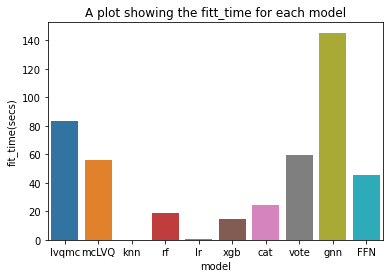

In [49]:
sns.barplot(data=results_df,x='model',y='fit_time(secs)')
plt.title('A plot showing the fitt_time for each model')
plt.show()

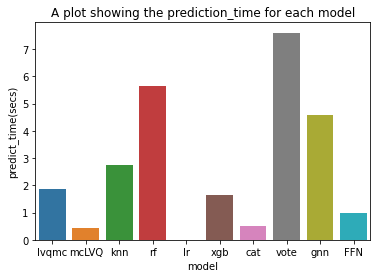

In [50]:
sns.barplot(data=results_df,x='model',y='predict_time(secs)')
plt.title('A plot showing the prediction_time for each model')
plt.show()

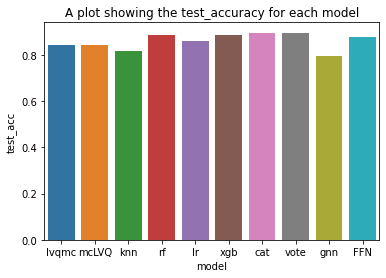

In [51]:
sns.barplot(data=results_df,x='model',y='test_acc')
plt.title('A plot showing the test_accuracy for each model')
plt.show()

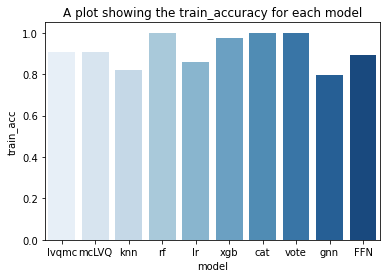

In [52]:
sns.barplot(data=results_df,x='model',y='train_acc',palette = "Blues")
plt.title('A plot showing the train_accuracy for each model')
plt.show()

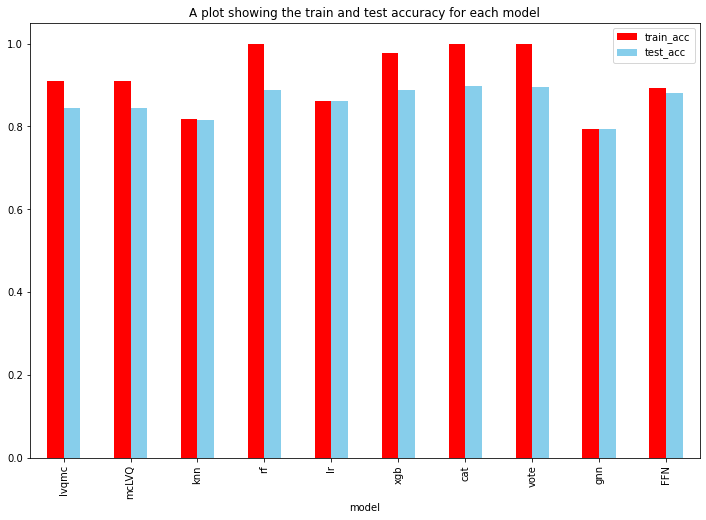

In [53]:
results_df.plot(y=['train_acc','test_acc'],x='model',kind='bar', stacked=False, color=['red', 'skyblue'],figsize=(12,8))
plt.title('A plot showing the train and test accuracy for each model')
plt.show()

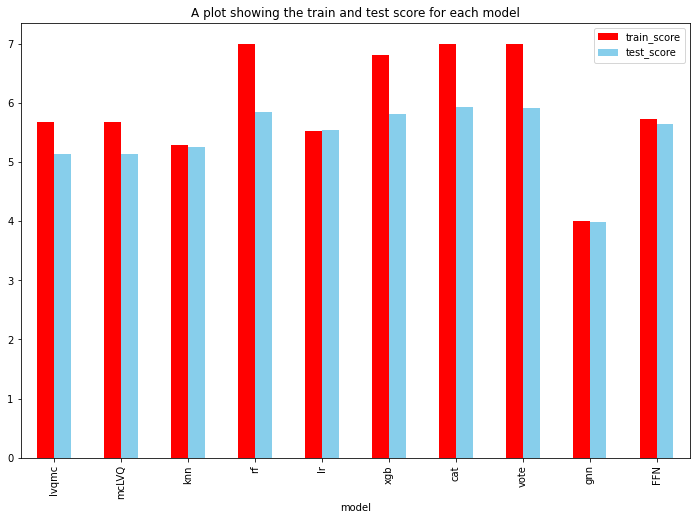

In [54]:
results_df.plot(y=['train_score','test_score'],x='model',kind='bar', stacked=False, color=['red', 'skyblue'],figsize=(12,8))
plt.title('A plot showing the train and test score for each model')
plt.show()

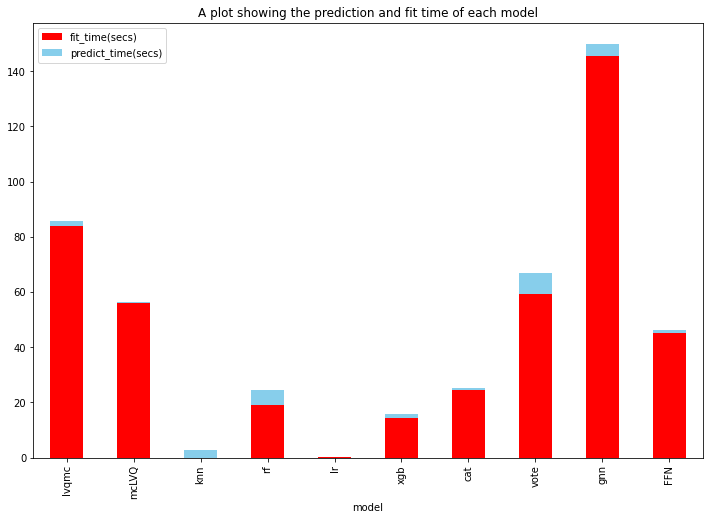

In [55]:
results_df.plot(y=['fit_time(secs)','predict_time(secs)'],x='model',kind='bar', stacked=True, color=['red', 'skyblue'],figsize=(12,8))
plt.title('A plot showing the prediction and fit time of each model')
plt.show()